# StreamMultiDiffusion SDXL Streaming Pipeline Demo

For additional info, please consult our paper: [StreamMultiDiffusion: Real-Time Interactive Generation with Region-Based Semantic Control](https://arxiv.org/abs/2403.09055). Especially the appendices for the usage of this application.

## Preparation

In [1]:
seed = 0
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from functools import reduce
from PIL import Image
from diffusers.utils import make_image_grid
from IPython.display import clear_output

from util import seed_everything, Streamer
from model import StreamMultiDiffusionSDXL
from ipython_util import dispt
from prompt_util import print_prompts, preprocess_prompts


device = f'cuda:{device}'
seed_everything(seed)
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 0
[INFO] Initialized with device: cuda:0


[INFO] Loading masks...


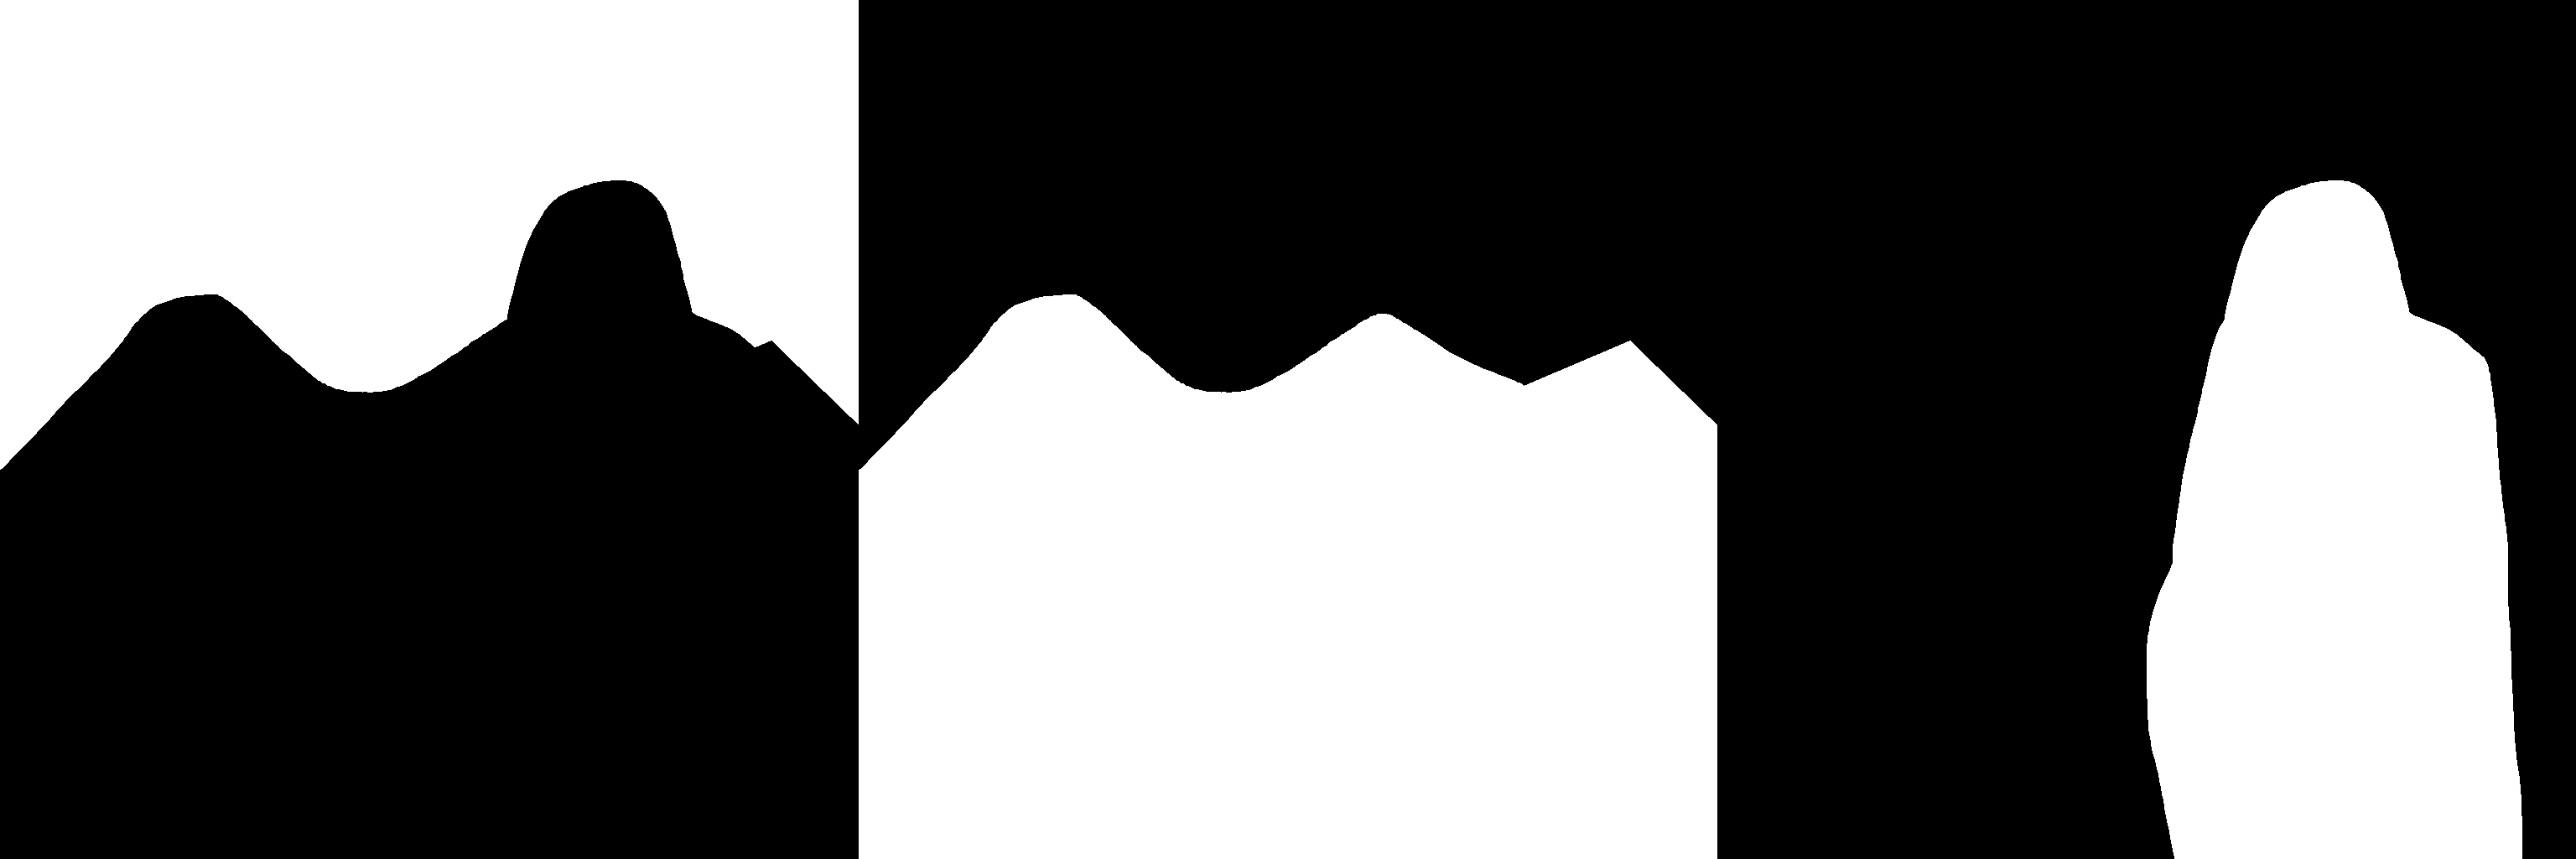

[INFO] Loading prompts...
Background Prompt: purple sky, planets, planets, planets, stars, stars, stars, masterpiece, best quality, very aesthetic, absurdres
Prompt1: a photo of the dolomites, masterpiece, absurd quality, background, no humans, masterpiece, best quality, very aesthetic, absurdres
Prompt2: 1girl, looking at viewer, pretty face, blue hair, fantasy style, witch, magi, robe, masterpiece, best quality, very aesthetic, absurdres
Background Negative Prompt: nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract], worst quality, bad quality, normal quality, cropped, framed, 1girl, 1boy, humans, humans, humans
Negative Prompt1: nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberrati

In [3]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'fantasy_large'
mask_all = Image.open(f'../assets/{name}/{name}_full.png').convert('RGBA')
masks = [Image.open(f'../assets/{name}/{name}_{i}.png').convert('RGBA') for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background is simply non-marked set of pixels.
background = reduce(torch.logical_and, [m == 0 for m in masks])
dispt([background] + masks, row=1)

masks = torch.stack([background] + masks, dim=0)
mask_strengths = 1.0
mask_stds = 0.0
prompt_strengths = 1.0

###

# Prepare prompts.
print('[INFO] Loading prompts...')

prompts = [
    # Background prompt.
    'purple sky, planets, planets, planets, stars, stars, stars',
    # Foreground prompts.
    'a photo of the dolomites, masterpiece, absurd quality, background, no humans',
    '1girl, looking at viewer, pretty face, blue hair, fantasy style, witch, magi, robe',
]
negative_prompts = [
    '1girl, 1boy, humans, humans, humans',
    '1girl, 1boy, humans, humans, humans',
    '',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]

###

# Preprocess prompts for better results.
quality_name = 'Standard v3.1'
style_name = '(None)'

prompts, negative_prompts = preprocess_prompts(
    prompts, negative_prompts, style_name=style_name, quality_name=quality_name)

###

print_prompts(prompts, negative_prompts, has_background=True)
height, width = masks.shape[-2:]

# Run

## Step 1: Load a StreamMultiDiffusion pipeline.

In [4]:
streamer = StreamMultiDiffusionSDXL(
    device,
    hf_key='cagliostrolab/animagine-xl-3.1',
    height=height,
    width=width,
    cfg_type="none",
    autoflush=True,
    use_tiny_vae=False,
    mask_type='continuous',
    bootstrap_steps=1,
    bootstrap_mix_steps=1,
    seed=seed,
)

[INFO]     Loading Stable Diffusion...
[INFO] Using Hugging Face custom model key: cagliostrolab/animagine-xl-3.1


Loading checkpoint shards: 100%|█████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


[INFO]     Model is loaded!
[INFO]     Parameters prepared!


## Step 2: Register background image (white image is OK).

In [5]:
streamer.update_background(Image.new(size=(width, height), mode='RGB', color=(255, 255, 255)))

True

## Step 3: Register *semantic palette*.

Semantic palette is a list of pairs (text prompt, mask), which we call a *semantic brush/layer*. This is a basic unit of drawing in the multiple region-based text-to-image synthesis.

In [6]:
# Register semantic palette at once.
streamer.update_layers(
    prompts=prompts,
    negative_prompts=negative_prompts,
    masks=masks.to(device),
    mask_strengths=mask_strengths,
    mask_stds=mask_stds,
    prompt_strengths=prompt_strengths,
)

# Or register each semantic brush one by one.
# for i in range(len(prompts)):
#     streamer.update_single_layer(
#         idx=i,
#         prompt=prompts[i],
#         negative_prompt=negative_prompts[i],
#         mask=masks[i],
#         mask_strength=1.0,
#         mask_std=0.0,
#         prompt_strength=1.0,
#     )

## Step 4: Generate forever.

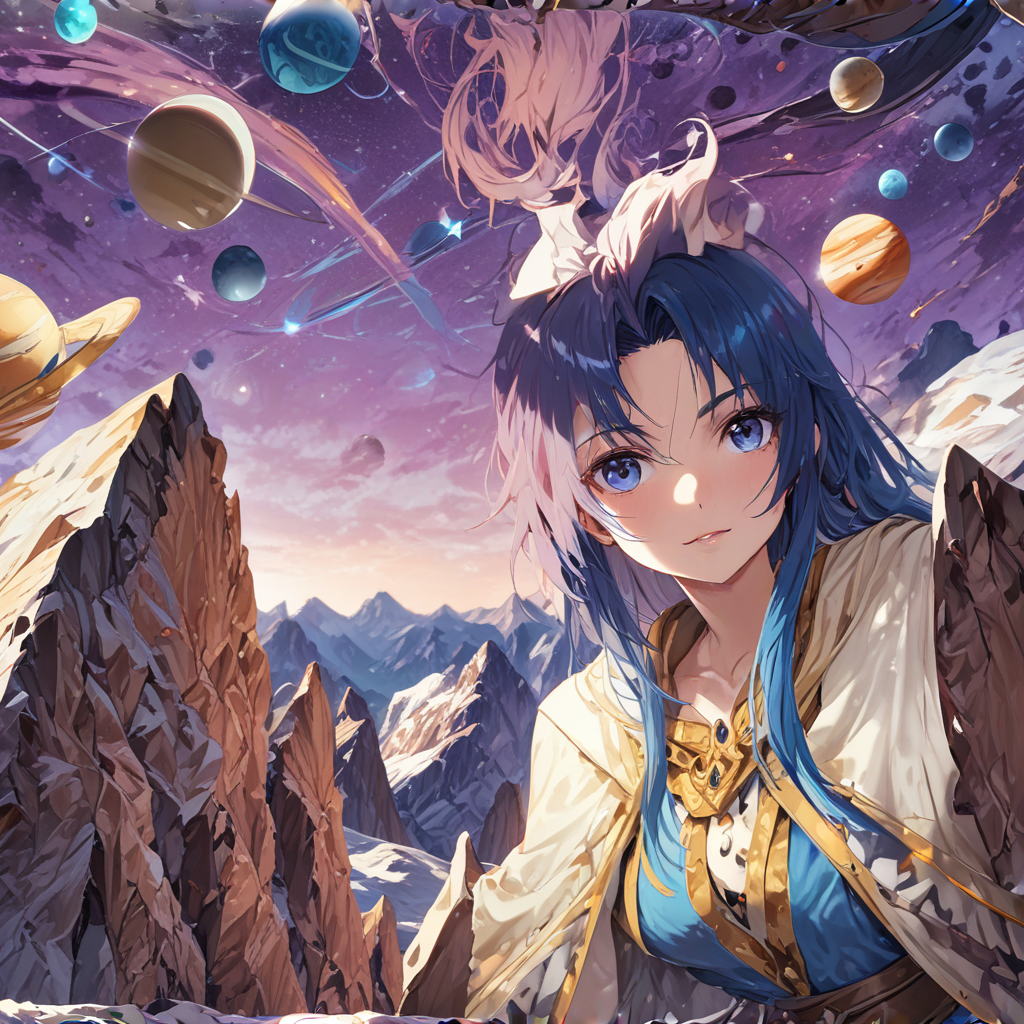

In [7]:
while True:
    display(streamer())
    time.sleep(1.0)
    clear_output()